# Unsupervised learning workshop

The goal of unsupervised  learning is generally to find patterns in a dataset with minimal human input. Perhaps the data is unlabeled, and the goal could be exploration, or due to some intuition or information about the dataset there is an expected pattern and the goal is to tease it out. Perhaps the data is partially labeled, and the goal is to group unlabeled data with labeled data (this was essentially the goal of my insight project).

Dimensionality reduction via decomposition also falls under the umbrella of unsupervised learning, for example matrix factorization which can be used to build recommender systems. Decomposition can also be a step towards another model, as dimensionality reduction can improve performance (not just computational!) for high-dimensional and sparse data.

Anomaly detection is often described as semi-supervised learning, however it can be fully unsupervised. My understanding is that the difference lies in whether the model is initially trained on data containing outliers. I'll talk about this more later on when I show some examples.

There are also unsupervised NN techniques, which I'm not going to cover due to both a lack of time and more crucially a lack of understanding. I would be super interested if somebody stepped up to give a workshop on that topic! Finally there are many more unsupervised techniques than I'm going to cover here, but I'll try to make suggestions for further reading as we go!

Types of unsupervised learning:
* Blind signal separation / Decomposition
* Clustering
* Anomaly detection
* More!

## Blind signal separation AKA Decomposition

Blind signal separation, as the name implies, covers a range of techniques for recovering unknown source signals from some data with minimal information about how the signals were mixed into the data. This is a broad topic with applications outside of machine learning. It is used in digital signal processing, for a classical example see the [cocktail party problem](https://en.wikipedia.org/wiki/Cocktail_party_problem).

In machine learning context, BSS techniques usually seem to go by the name decomposition, and can be used for dimensionality reduction (PCA), recommendation (SVD/NNMF), or indeed for signal separation (ICA).

### Principal component analysis

Principal component analysis hand-wavy explanation using words stolen from wikipedia: For some collection data points in n-dimensions, you can always define a best fitting line, for example with least squares. You can then define another best fitting line in a direction orthogonal to the first line. This process can be repeated to yield an orthogonal basis, where the basis vectors are called principal components. The original data can be transformed into this basis, which can be of lower dimensionality than the original data while still capturing some or all of the variance in the data.

The dimensionality reduction by itself can already be very useful: Maybe you have high dimensional data and you want to be able to visualize it in a scatter plot, accepting that you will lose some information by doing so. Maybe you have some very high dimensional data (hopefully you've done some feature selection first!) that you are throwing into another model and you need to speed up training, or you believe the high dimensionality itself is causing issues (curse of dimensionality)!

Anyway, let's dive into a simple example with some data we're all familiar with.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cols = ["Thickness", "U Cell Size", "U Cell Shape", "Adhesion", "SE Cell Size", "Bare Nuclei", "Bland Chromatin",
       "Normal Nuclei", "Mitoses", "Class"]
patient_data = pd.read_csv("./breast-cancer-wisconsin.csv", header=None, index_col=0, names=cols)
patient_data = patient_data[patient_data.loc[:,"Bare Nuclei"] != "?"]
patient_data["Bare Nuclei"] = pd.to_numeric(patient_data["Bare Nuclei"])
patient_data["Class"] = np.where(patient_data["Class"] == 4, 1, 0)

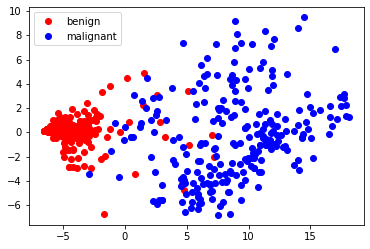

In [259]:
from sklearn.decomposition import PCA

X, y = patient_data.iloc[:,:-1], patient_data.iloc[:,-1]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.plot(X_pca[:,0][y==0], X_pca[:,1][y==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][y==1], X_pca[:,1][y==1], 'o', color='b', label='malignant')
plt.legend()

### Explained variance

Explained variance is a measure of how much a given model accounts for the dispersion of a dataset. The PCA transformation will tend to lose information in this way, i.e. fail to account for all of the variance in a dataset. Looking at the explained variance is a way to determine how much information you are losing due to PCA. That is the case in the example below.

On the other hand, this can also reveal that almost all of the variance in your n-dimensional data is captures by some (n-m)-dimensional PCA transformation. I don't think this necessarily means that some of your features are redundant (invite expert opinion here).

Text(0, 0.5, 'cumulative explained variance')

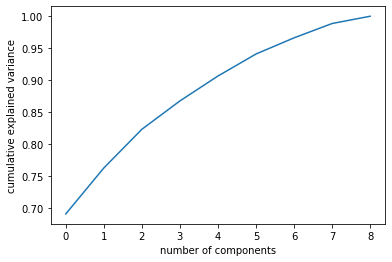

In [9]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Other forms of PCA available in scikit-learn

[documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca)

The example above used "vanilla" PCA, which has some drawbacks:
1. Because the dataset is centered before the transformation, it doesn't perform well for sparse matrices
2. Entire dataset has to be stored in memory, which can be difficult for large datasets.
3. PCA transformation gives a dense representation, i.e. output can't be sparse, even if a sparse representation might be more sensible.

For sparse data, its recommended to use SVD instead of PCA, which is my next example.

If sparse output is desired, sklearn's SparsePCA introduces an l1 penalty to shrink some coefficients to zero.

IncrementalPCA aims to address the memory issue of PCA using partial computation so that the entire dataset is never stored in memory.

### Singular Value Decomposition -- TruncatedSVD

Singular value decomposition is a well known matrix decomposition method, so I won't go into the math! The "truncated" in TruncatedSVD is to indicate that rather than doing a full decomposition, it will be truncated after computing the k largest single values, where k is a user input. SVD doesn't have the centering requirement of PCA and thus performs better on sparse matrices. One obvious application is in NLP, where it is not unusual to have large, sparse matrices!

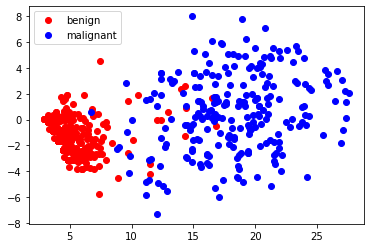

In [196]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

plt.plot(X_svd[:,0][y==0], X_svd[:,1][y==0], 'o', color='r', label='benign')
plt.plot(X_svd[:,0][y==1], X_svd[:,1][y==1], 'o', color='b', label='malignant')
plt.legend(loc="upper left")

### Independent component analysis

ICA is a technique for decomposing some "signal" into additive subcomponents. It determines a new set of features and coefficients, such that features in the original data can be represented as linear combinations of the new features and coefficents.

In order for this to work, the new features are assumed to be non-Gaussian and statistically independent. ICA works particularly well for decomposing sound data!

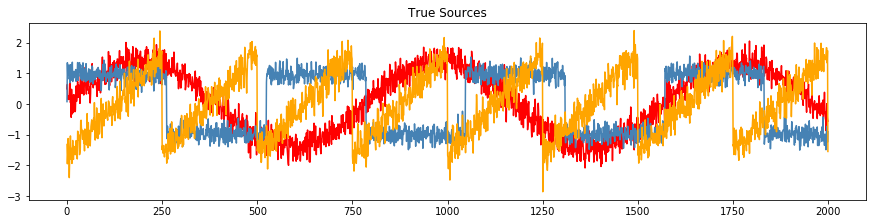

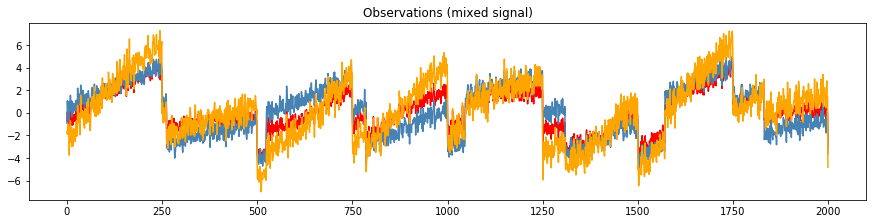

In [256]:
from scipy import signal

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X_ica = np.dot(S, A.T)  # Generate observations

models = [S, X_ica]
names = ["True Sources", "Observations (mixed signal)"]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.figure(figsize=(15, 15))
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
    plt.show()

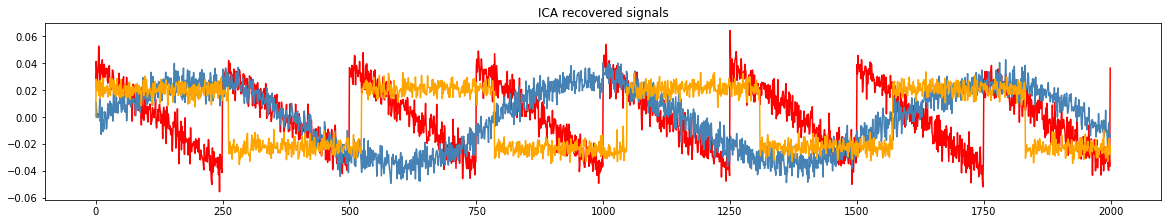

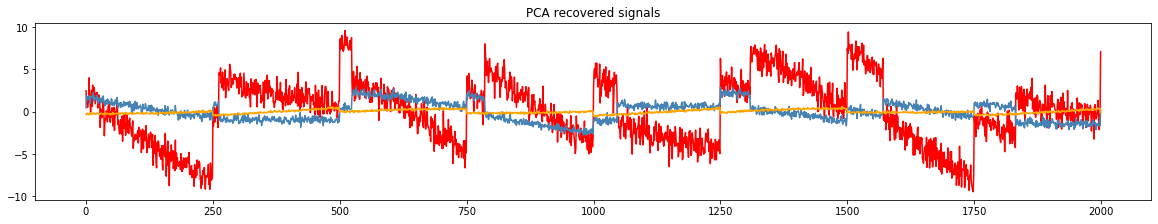

In [258]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
S_ = ica.fit_transform(X_ica)  # Reconstruct signals

pca = PCA(n_components=3)
H = pca.fit_transform(X_ica)  # Reconstruct signals based on orthogonal components

models = [S_, H]
names = ["ICA recovered signals", "PCA recovered signals"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.figure(figsize=(20, 15))
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
    plt.show()

## Clustering

One sentence explanation: Clustering will find groups or segments in the data that are similar.

Two obvious questions:
* How many groups/segments?
* What do we mean by similar?

How many groups/segments will obviously depend on the data. You might not even know ahead of time, in which case you might tune it as a hyperparameter, or use an algorithm that is agnostic to the number of clusters.

There are many ways to measure the similarity, or distance, and this can also be model dependent so it will be discussed for each model.

### Hierarchical clustering

Hierarchical clustering builds a tree-like structure of nested clusters by successively merging or splitting clusters, depending on whether a top-down (Divisive) or bottom-up (Agglomerative) approach is taken. Divisize is more complex since some other clustering algorithm needs to be run as a subroutine to decide the splitting at each step. I couldn't actually find an implementation of divisive hierarchical clustering, but Agglomerative is available in scikit-learn and scipy.

Similarity/Distance measures:
* Euclidean
* Cosine
* Manhattan
* Hamming/Jacard
* More! Generally customizable.

Clustering strategies:
* Ward: minimizes sum of squared distances of all data points within pairs of clusters. 
* Complete: minimizes maximum distance between data points in pairs of clusters.
* Average: minimizes the average of the distances between all data points of pairs of clusters.
* Single/Simple: minimizes the distance between the closest data points in pairs of clusters.

<img src="./images/clustering_affinities.png">

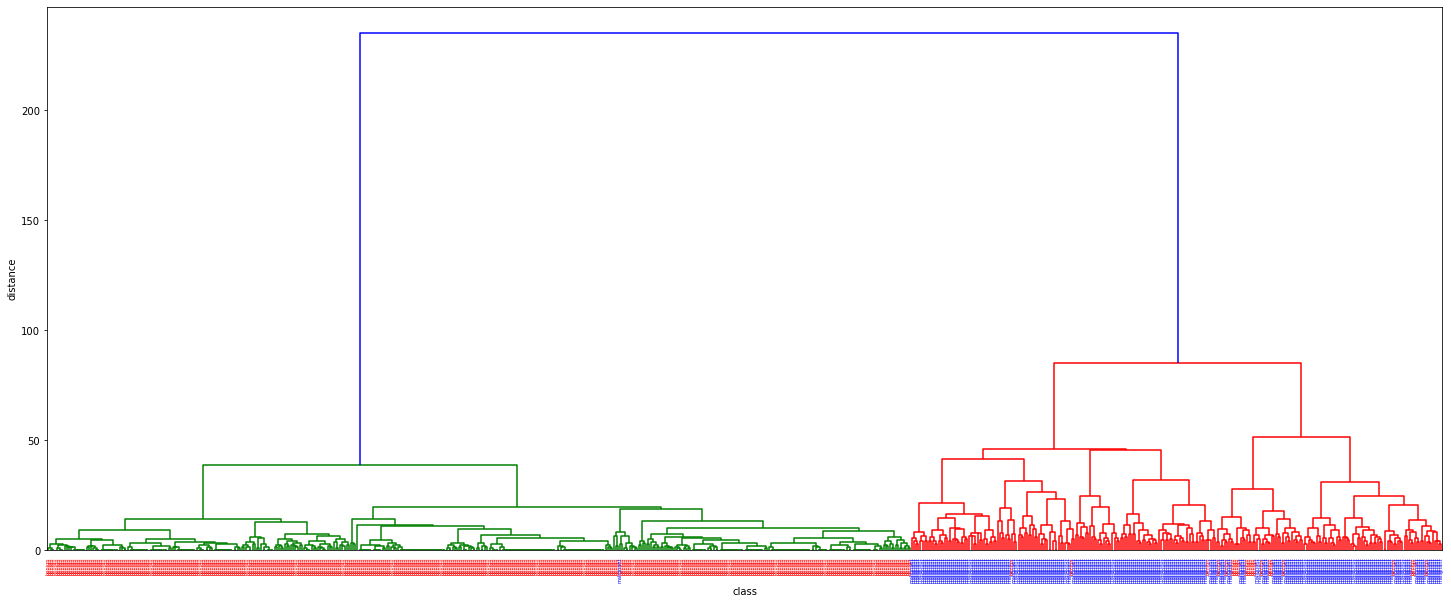

In [260]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Reassign these here just in case
X, y = patient_data.iloc[:,:-1], patient_data.iloc[:,-1]

Z = linkage(X, 'ward', metric='euclidean')
fig = plt.figure(figsize=(25, 10))
plt.xlabel("class")
plt.ylabel("distance")
dendro = dendrogram(Z, labels=np.where(y==0, "benign", "malignant"))
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() == "benign":
        lbl.set_color('r')
    else:
        lbl.set_color('b')
plt.show()

### K-means clustering

Seperates data into n clusters by minimizing the inertia, or the in-cluster sum-of-squares:

$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$

Where $x_i$ are the centroids of the clusters (C) and $\mu_j$ are the data. Since k-means relies on the cluster centroids, the distance metric is euclidean.

Some draw backs:
* Minimizing inertia assumes clusters are convex and isotropic. Will not perform well in other situations.
* High-dimensional and/or sparse data can lead to inflated euclidean distances and poor performance. Can be alleviated to some degree by running a dimensionality reduction algorithm like PCA beforehand.



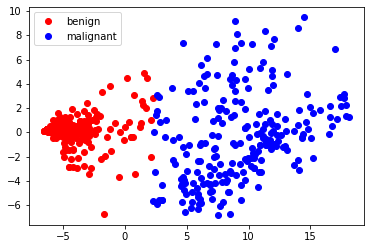

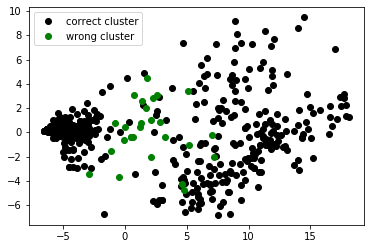

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.plot(X_pca[:,0][kmeans.labels_==0], X_pca[:,1][kmeans.labels_==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][kmeans.labels_==1], X_pca[:,1][kmeans.labels_==1], 'o', color='b', label='malignant')
plt.legend()
plt.show()
plt.plot(X_pca[:,0][kmeans.labels_==y], X_pca[:,1][kmeans.labels_==y], 'o', color='k', label='correct cluster')
plt.plot(X_pca[:,0][kmeans.labels_!=y], X_pca[:,1][kmeans.labels_!=y], 'o', color='g', label='wrong cluster')
plt.legend()
plt.show()

### DBSCAN

DBSCAN treats clusters as areas of high density that are seperated by areas of low density. To achieve this, it takes at least two parameters:

1. eps = the maximum distance between two points for them to be considered as in the same neighbourhood
2. min_samples = the minimum number of neighbouring points for a point to be considered a "core" point

The algorithm proceeds by first identifying the core points using eps/min_samples, and building clusters outwards from those core points. Points that aren't in the neighbourhood of any clusters are left out of the clustering and marked as noise.

It has major computational advantages over hierarchical clustering as it doesn't need to know pair-wise distances between all points in the dataset, only distances between core points and their neighbours are important. It also has a flexibility advantage over k-means, clusters can be any shape/size.

Estimated number of clusters: 2
Estimated number of noise points: 136


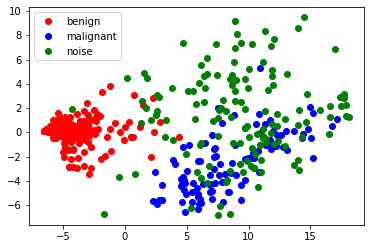

In [166]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
plt.plot(X_pca[:,0][labels==0], X_pca[:,1][labels==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][labels==1], X_pca[:,1][labels==1], 'o', color='b', label='malignant')
plt.plot(X_pca[:,0][labels==-1], X_pca[:,1][labels==-1], 'o', color='g', label='noise')
plt.legend()

### Documentation for other clustering algorithms:

There are many other options for clustering algorithms, I couldn't cover them all here! Picking the right clustering algorithm is generally going to depend on the form of your data. For docs on the scikit-learn implementations, use this link:

[documentation](https://scikit-learn.org/stable/modules/clustering.html)

### Validating clustering output

**Cophenetic correlation coefficient**: Correlation between the array of pair-wise distances between original points, and array of inter-cluster distances. A measure of how well the clustering did at clustering "similar" data points. Not implemented in scikit-learn!

**Silhouette score**: Calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample, where b is the nearest cluster that the sample is not a part of. For a given sample: 

score = (b - a)/max(a, b)


In [280]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score

# Note: Using the hierarchical clustering output here
print("Cophenetic correlation coefficient of hierararchical clustering: {}".format(cophenet(Z, pdist(X))[0]))

# Note: Using the k-means clustering output here
print("Silhouette score of k-means clustering: {}".format(silhouette_score(X, kmeans.labels_)))

Cophenetic correlation coefficient of hierararchical clustering: 0.8044186156741031
Silhouette score of k-means clustering: 0.5967981179111456


## Anomaly detection

Anomaly detection can be broadly split into two categories.

1. **Unsupervised AKA Outlier  detection** -- training data is contaminated with outliers, algorithms try to fit dense regions in the training data to identify outliers.
2. **(semi) Supervised AKA Novelty detection** -- training data is **not** contaminated with outliers, algorithms should identify whether new observations are consistent with the training data or are outliers.

In either case the goal is anomaly detection, however the unsupervised version has the limitation that the outliers cannot form a dense cluster as available algorithms assume that outliers are located in low density regions. Novelty detection does not suffer from this constraint, outliers can form a dense cluster **as long as they occur in a low density region in the training data**.

I'm going to treat my examples as if they are unsupervised, but my toy data will actually be labeled so we can get an idea of how well each algorithm is doing. Let's start by creating a toy dataset.

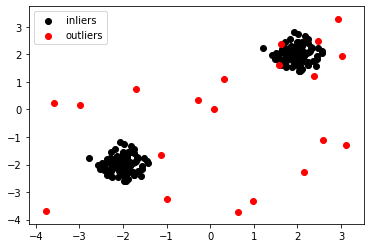

In [167]:
np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.concatenate([X_inliers + 2, X_inliers - 2], axis=0)

X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

X_all = np.concatenate([X_inliers, X_outliers], axis=0)
y_true = np.ones(len(X_all), dtype=int)
y_true[-len(X_outliers):] = -1

plt.scatter(X_inliers[:,0], X_inliers[:,1], color='k', label='inliers')
plt.scatter(X_outliers[:,0], X_outliers[:,1], color='r', label='outliers')
plt.legend()
plt.show()

### One class SVM

We're already familiar with SVM from a previous workshop. This is a reformulation that, rather than trying to "split" our data into two or more classes, tries to form a boundary identifying a single class. Anything outside the boundary is an outlier!

Parameters tuned in the example:
1. **kernel** -- for convex clusters as in our toy dataset RBF is probably the most sensible choice
2. **gamma** -- a scale that will control the influence of a single training data point
3. **nu** -- upper bound on the allowed number of training errors

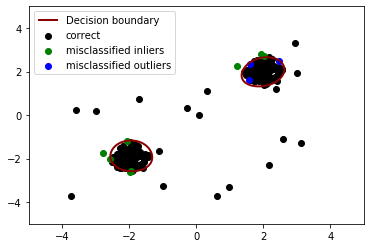

In [284]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(nu=0.12, kernel="rbf", gamma=0.25)
y_pred = svm.fit_predict(X_all)
y_pred_in, y_pred_out = y_pred[:len(X_inliers)], y_pred[len(X_inliers):]
y_true_in, y_true_out = y_true[:len(X_inliers)], y_true[len(X_inliers):]

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
b1 = plt.scatter(X_all[:,0][y_pred == y_true], X_all[:,1][y_pred == y_true], color='k', label='correct')
b2 = plt.scatter(X_inliers[:,0][y_pred_in != y_true_in], X_inliers[:,1][y_pred_in != y_true_in], 
            color='g', label="misclassified inliers")
b3 = plt.scatter(X_outliers[:,0][y_pred_out != y_true_out], X_outliers[:,1][y_pred_out != y_true_out], 
            color='b', label="misclassified outliers")
plt.legend([a.collections[0], b1, b2, b3], ["Decision boundary", "correct", "misclassified inliers", "misclassified outliers"],
           loc="upper left")
plt.show()

### Local outlier factor

Searches for sample that have a substantially lower density than their neighbours by measuring the local density deviation of a given data point with respect to its neighbours.

The "LOF score" of a sample is equal to the ratio of the average local density of its k-nearest neighbors, and its own local density. A normal instance is expected to have a local density similar to that of its neighbors, while abnormal data are expected to have much smaller local density.


Prediction errors: 7


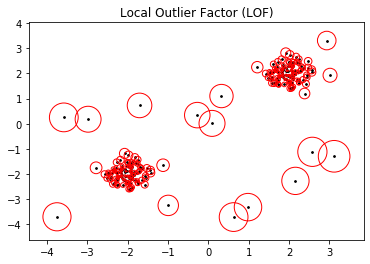

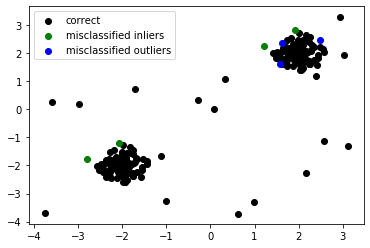

In [290]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_all)
n_errors = (y_pred != y_true).sum()
print("Prediction errors: {}".format(n_errors))

X_scores = clf.negative_outlier_factor_

# Plot the original data with red circles of radius proportional to the model prediction
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_all[:, 0], X_all[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X_all[:, 0], X_all[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

# Plot the original data with misclassified data points highlighted
y_pred_in, y_pred_out = y_pred[:len(X_inliers)], y_pred[len(X_inliers):]
y_true_in, y_true_out = y_true[:len(X_inliers)], y_true[len(X_inliers):]
plt.scatter(X_all[:,0][y_pred == y_true], X_all[:,1][y_pred == y_true], color='k', label='correct')
plt.scatter(X_inliers[:,0][y_pred_in != y_true_in], X_inliers[:,1][y_pred_in != y_true_in], 
            color='g', label='misclassified inliers')
plt.scatter(X_outliers[:,0][y_pred_out != y_true_out], X_outliers[:,1][y_pred_out != y_true_out], 
            color='b', label='misclassified outliers')
plt.legend()
plt.show()

### Isolated Forest

The Isolated Forest algorithm ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

The number of splittings required to isolate a sample in an individual tree is taken as a path length, and the average path length over many random trees is used as a measure of the "normality" of the sample. Random partitioning of the dataset tends to introduce shorter path lengths for anomalies!

Prediction errors: 7


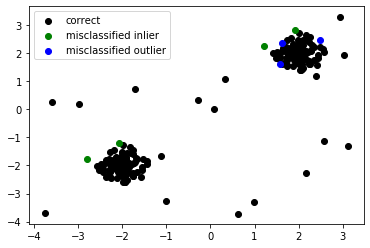

In [293]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(max_samples=200)
y_pred = isof.fit_predict(X_all)
n_errors = (y_pred != y_true).sum()
print("Prediction errors: {}".format(n_errors))
y_pred_out = isof.predict(X_outliers)
y_pred_in = isof.predict(X_inliers)

plt.scatter(X_all[:,0][y_pred == y_true], X_all[:,1][y_pred == y_true], c='k', label="correct")
plt.scatter(X_inliers[:,0][y_pred_in != y_true_in], X_inliers[:,1][y_pred_in != y_true_in], c='g', label="misclassified inlier")
plt.scatter(X_outliers[:,0][y_pred_out != y_true_out], X_outliers[:,1][y_pred_out != y_true_out], c='b', label="misclassified outlier")
plt.legend()

## Further exploration

Some topics I didn't cover today that I think would be interesting and worthwhile to look at:
* Non-negative matrix factorization
* Autoencoders
* Generative Adversarial Networks
* Self organizing maps